In [1]:
import os, sys
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt

from load_blender import load_blender_data

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


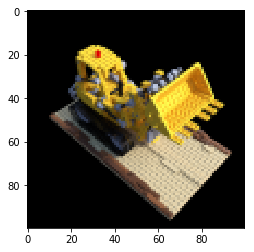

In [2]:
# Load input images

data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]

plt.imshow(testimg)
plt.show()

0 7.464846


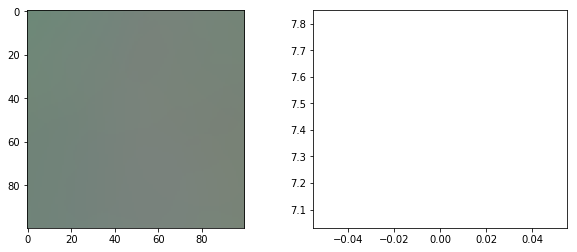

25 10.008738


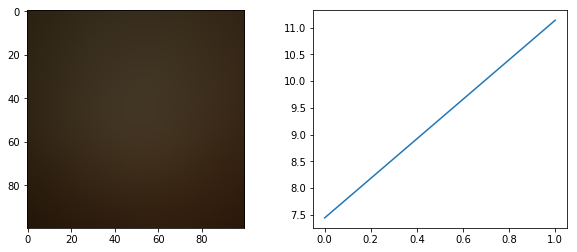

50 11.692827


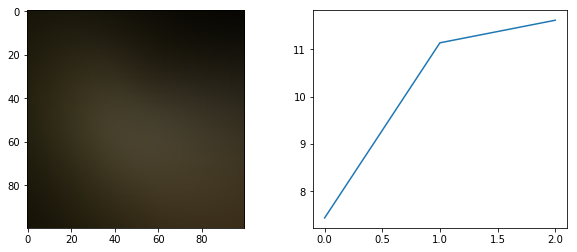

75 11.175313


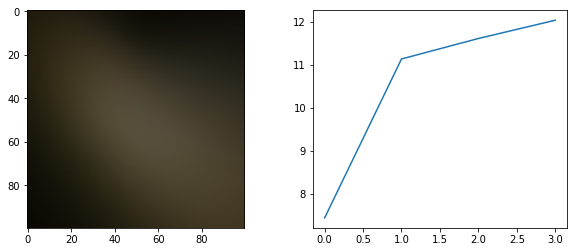

100 14.114131


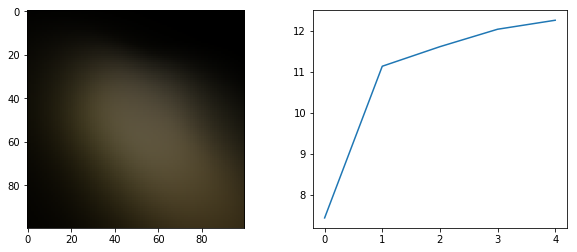

125 13.009188


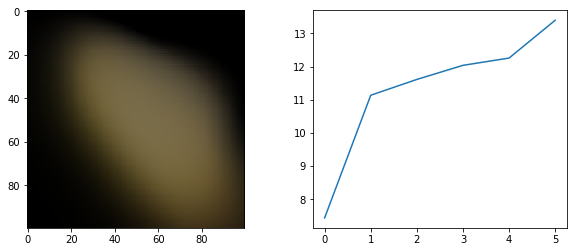

150 17.593643


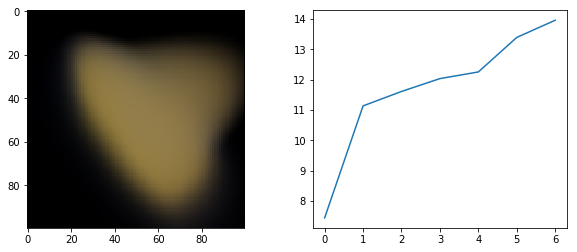

175 14.684128


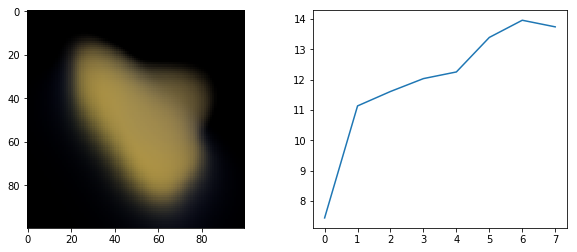

200 16.09077


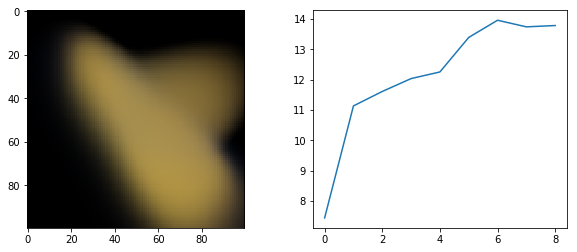

225 17.975826


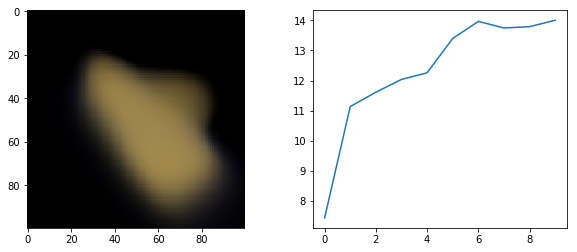

250 16.740053


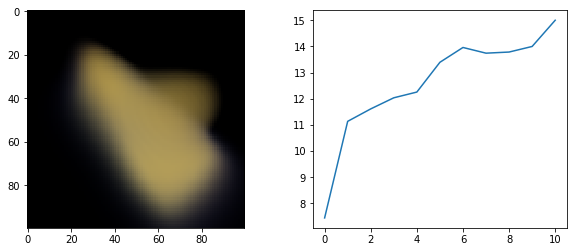

275 14.604501


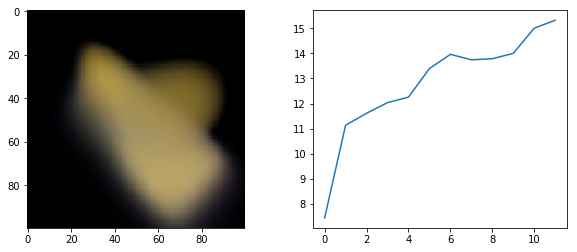

300 17.067432


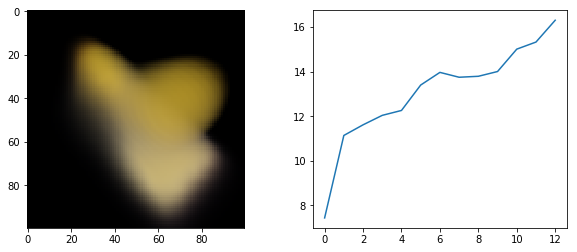

325 15.510721


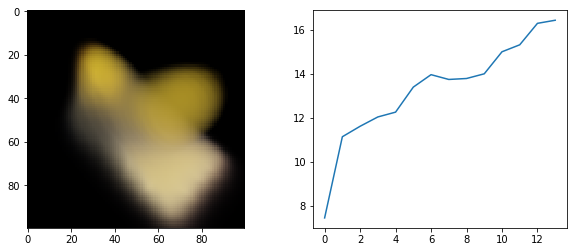

350 17.514088


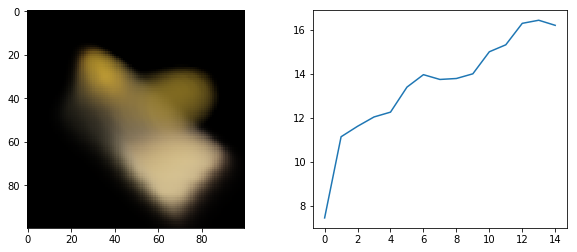

375 17.761621


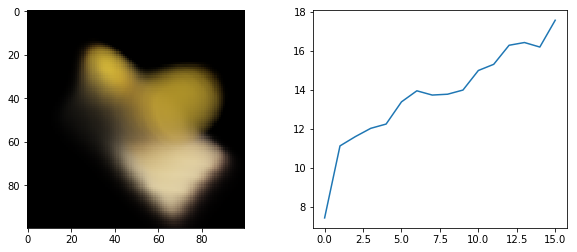

400 16.806349


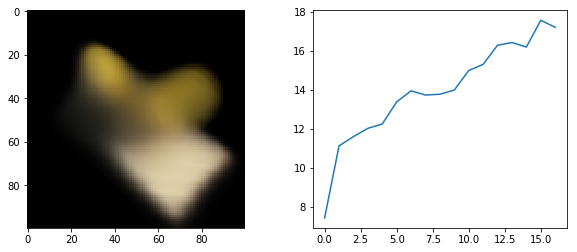

425 17.314363


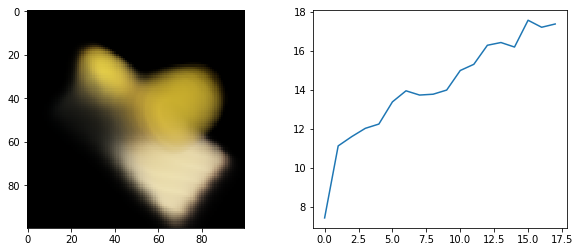

450 18.491533


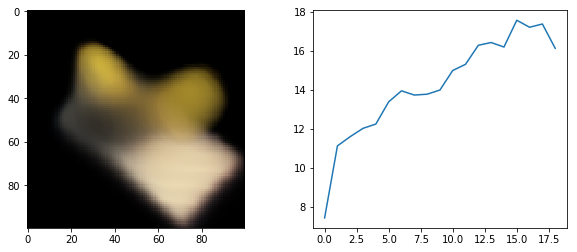

475 20.120472


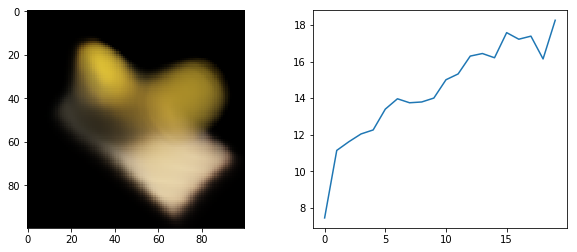

500 19.882067


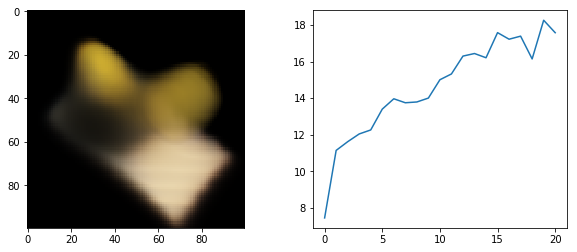

KeyboardInterrupt: 

In [3]:

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()    
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3)) 
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d


def render_rays(network_fn, rays_o, rays_d, near, far, N_samples):
    
    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples) 
#     z_vals = tf.sort(tf.random.uniform([N_samples], near, far))
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    
    # Run network
    pts_flat = tf.reshape(pts, [-1,3])
    raw = network_fn(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3]) 
    
    # Do volume rendering
    dists = tf.concat([z_vals[1:] - z_vals[:-1], [1e10]], -1) 
    alpha = 1.-tf.exp(-sigma_a * dists)  
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)
    
    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2) 
    depth_map = tf.reduce_sum(weights * z_vals, -1) 
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map


model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 32
N_iters = 10000
psnrs = []

for i in range(N_iters):
    
    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    if i%25==0:
        print(i, psnr.numpy())
        
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)
        psnrs.append(psnr.numpy())
        
        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.subplot(122)
        plt.plot(psnrs)
        plt.show()


In [4]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w
    
# pose_spherical(angle, -30.0, 4.0)
    

def f(**kwargs):
    
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)
    
    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()
    

sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…